In [3]:
%matplotlib inline
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from HDF5DatasetWriter import HDF5DatasetWriter
from HDF5DatasetGenerator import HDF5DatasetGenerator
from utils import *
from tqdm import tqdm
import cv2
from skimage import io
import SimpleITK as sitk
import re
import sys
import scipy.ndimage
from skimage import measure, morphology

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

### getRangImageDepth函数
使每个病人的矩阵里只保留含肿瘤的图，可以在代码里删除对应的函数和调用，获得每个病人的矩阵对应所有的图

In [2]:
import numpy as np
import cv2
import re
import sys
import SimpleITK as sitk

def get_pixels_hu(scans):
    #type(scans[0].pixel_array)
    #Out[15]: numpy.ndarray
    #scans[0].pixel_array.shape
    #Out[16]: (512, 512)
    # image.shape: (129,512,512)
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def transform_ctdata(image, windowWidth, windowCenter, normal=False):
        """
        注意，这个函数的self.image一定得是float类型的，否则就无效！
        return: trucated image according to window center and window width
        """
        minWindow = float(windowCenter) - 0.5*float(windowWidth)
        newimg = (image - minWindow) / float(windowWidth)
        newimg[newimg < 0] = 0
        newimg[newimg > 1] = 1
        if not normal:
            newimg = (newimg * 255).astype('uint8')
        return newimg

def getRangImageDepth(image):
    """
    args:
    image ndarray of shape (depth, height, weight)
    """
    # 得到轴向上出现过目标（label>=1)的切片
    z = np.any(image, axis=(1,2)) # z.shape:(depth,)
    startposition,endposition = np.where(z)[0][[0,-1]]
    return startposition, endposition

# def getRangImageDepth(image):
#     """
#     args:
#     image ndarray of shape (depth, height, weight)
#     """
#     firstflag = True
#     startposition = 0
#     endposition = 0
#     for z in range(image.shape[0]):
#         notzeroflag = np.max(image[z])
#         if notzeroflag and firstflag:
#             startposition = z
#             firstflag = False
#         if notzeroflag:
#             endposition = z
#     return startposition, endposition

def clahe_equalized(imgs,start,end):
    assert (len(imgs.shape)==3)  #3D arrays
    #create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(start, end+1):
        imgs_equalized[i,:,:] = clahe.apply(np.array(imgs[i,:,:], dtype = np.uint8))
    return imgs_equalized

def get_highest_acc():
    pattern = 'model.(?P<epoch>\d+)-(?P<val_acc>[0-9]*\.?[0-9]*).hdf5'
    p = re.compile(pattern)
    acces = [float(p.match(f).groups()[1]) for f in os.listdir('models/') if p.match(f)]
    if len(acces) == 0:
        return sys.float_info.min
    else:
        return np.max(acces)


def get_pixels_hu_by_simpleitk(dicom_dir, intercept, slope):

    #读取某文件夹内的所有dicom文件,并提取像素值(-4000 ~ 4000)

    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    img_array = sitk.GetArrayFromImage(image)
    img_array[img_array == -2000] = 0

    # Convert to Hounsfield units (HU)
    
    if slope != 1:
        img_array = slope * img_array.astype(np.float64)
        img_array = img_array.astype(np.int16)
        
    img_array += np.int16(intercept)
    
    return np.array(img_array, dtype=np.int16)

def get_livers(data_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(data_path)
    dicom_names = [s[:-4]+'_mask.png' for s in dicom_names ]
    livers = np.array([plt.imread(s) for s in dicom_names])
    return livers

In [27]:
seed=1
#outputPath = "./data_train/all_liver.h5"
full_images2 = []
full_livers2 = []
for i in range(1,108):#后3个人作为测试样本
    if i != 1:
        continue
    if i == 16:
        continue
    data_path = './train/train/' + str(i+1000) + '/arterial phase'
    image_slices = [pydicom.dcmread(data_path + '/' + s) for s in os.listdir(data_path) if '.dcm' in s ]
    image_slices.sort(key = lambda x: int(x.InstanceNumber), reverse = True)#实验证明！逆序的！
    intercept = image_slices[0].RescaleIntercept
    slope = image_slices[0].RescaleSlope
    del image_slices
    livers = get_livers(data_path)
#================================================
    """ 省略进行的预处理操作，具体见part2"""
    #part2
    # 接part1
    images = get_pixels_hu_by_simpleitk(data_path, intercept, slope)
    images = transform_ctdata(images,3970,860)
    start,end = getRangImageDepth(livers)
    images = clahe_equalized(images,start,end)
    images /= 255.
    # 仅提取腹部所有切片中包含了肝脏的那些切片，其余的不要
    total = (end ) - (start) +1
    print("%d person, total slices %d"%(i,total))
    # 首和尾目标区域都太小，舍弃
    images = images[start:end]
    print("%d person, images.shape:(%d,)"%(i,images.shape[0]))
    livers[livers>0] = 1
    livers = livers[start:end]
    
   #=================================================
    full_images2.append(images)
    full_livers2.append(livers)
    
    print("%d Time finished"%(i))


full_images2 = np.vstack(full_images2)
full_images2 = np.expand_dims(full_images2,axis=-1)
full_livers2 = np.vstack(full_livers2)
full_livers2 = np.expand_dims(full_livers2,axis=-1)

1 person, total slices 6
1 person, images.shape:(5,)
1 Time finished


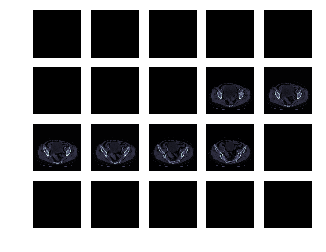

In [8]:
#这里没有
f, plots = plt.subplots(4, 5, sharex='all', sharey='all', figsize=(5, 4))
for i in range(20):
    plots[i // 5, i % 5].axis('off')
    plots[i//5 , i % 5].imshow(images[i], cmap=plt.cm.bone)

### 制作动图尝试

In [46]:
seed=1
#outputPath = "./data_train/all_liver.h5"
full_images2 = []
full_livers2 = []
for i in range(1,20):#后3个人作为测试样本
#     if i != 1:
#         continue
    if i == 16:
        continue
    data_path = './train/train/' + str(i+1000) + '/arterial phase'
    image_slices = [pydicom.dcmread(data_path + '/' + s) for s in os.listdir(data_path) if '.dcm' in s ]
    image_slices.sort(key = lambda x: int(x.InstanceNumber), reverse = True)#实验证明！逆序的！
    intercept = image_slices[0].RescaleIntercept
    slope = image_slices[0].RescaleSlope
    del image_slices
    livers = get_livers(data_path)
#================================================
    """ 省略进行的预处理操作，具体见part2"""
    #part2
    # 接part1
    images = get_pixels_hu_by_simpleitk(data_path, intercept, slope)
    images = transform_ctdata(images,3970,860)
    start,end = getRangImageDepth(livers)
    images = clahe_equalized(images,start,end)
    images /= 255.
    # 仅提取腹部所有切片中包含了肝脏的那些切片，其余的不要
    total = (end ) - (start) +1
    print("%d person, total slices %d"%(i,total))
    # 首和尾目标区域都太小，舍弃
    images = images[start:end]
    print("%d person, images.shape:(%d,)"%(i,images.shape[0]))
    livers[livers>0] = 1
    livers = livers[start:end]
    
   #=================================================
    full_images2.append(images)
    full_livers2.append(livers)
    
    print("%d Time finished"%(i))


full_images2 = np.vstack(full_images2)
full_images2 = np.expand_dims(full_images2,axis=-1)
full_livers2 = np.vstack(full_livers2)
full_livers2 = np.expand_dims(full_livers2,axis=-1)

1 person, total slices 6
1 person, images.shape:(5,)
1 Time finished


F:\Anaconda\envs\tensorflow-gpu\lib\site-packages\pydicom\filereader.py:399: UserWarning: Expected implicit VR, but found explicit VR - using explicit VR for reading
  warnings.warn(message, UserWarning)


2 person, total slices 6
2 person, images.shape:(5,)
2 Time finished
3 person, total slices 3
3 person, images.shape:(2,)
3 Time finished
4 person, total slices 12
4 person, images.shape:(11,)
4 Time finished
5 person, total slices 6
5 person, images.shape:(5,)
5 Time finished
6 person, total slices 8
6 person, images.shape:(7,)
6 Time finished
7 person, total slices 8
7 person, images.shape:(7,)
7 Time finished
8 person, total slices 10
8 person, images.shape:(9,)
8 Time finished
9 person, total slices 10
9 person, images.shape:(9,)
9 Time finished
10 person, total slices 4
10 person, images.shape:(3,)
10 Time finished
11 person, total slices 8
11 person, images.shape:(7,)
11 Time finished
12 person, total slices 9
12 person, images.shape:(8,)
12 Time finished
13 person, total slices 7
13 person, images.shape:(6,)
13 Time finished
14 person, total slices 5
14 person, images.shape:(4,)
14 Time finished
15 person, total slices 8
15 person, images.shape:(7,)
15 Time finished
17 person, t

In [9]:
# This function takes in a single frame from the DICOM and returns a single frame in RGB format.
# def normalise(img):
#     normed = (img * 255 / 14).astype(np.uint8) # Magic number, scaling to create int between 0 and 255
#     img2 = np.zeros([*img.shape, 3], dtype=np.uint8)
#     for i in range(3):
#         img2[:, :, i] = normed
#     return img2

In [12]:
#npat = [normalise(p) for p in images]
# npat = images * 255

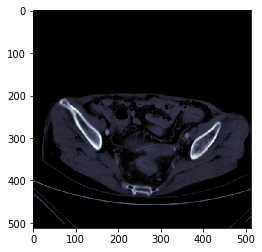

In [57]:
import matplotlib.animation as animation
def animate(pat, gifname):
    # Based on @Zombie's code
    fig = plt.figure()
    anim = plt.imshow(pat[0], cmap=plt.cm.bone)
    def update(i):
        anim.set_array(pat[i])
        return anim,
    
    a = animation.FuncAnimation(fig, update, frames=range(len(pat)), interval=10, blit=True)
    a.save(gifname, writer='imagemagick')
    
animate(full_images2.squeeze(), 'test.gif')

# 3D

In [56]:
print(images.shape)
print(images.transpose().shape)

print(full_images2.squeeze().shape)
print(full_images2.squeeze().transpose().shape)

(9, 512, 512)
(512, 512, 9)
(117, 512, 512)
(512, 512, 117)


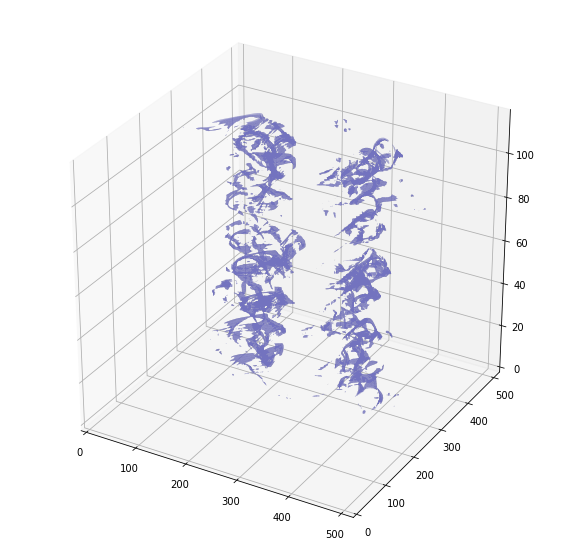

In [64]:
def plot_3d(image, threshold=-300):
    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    verts, faces = measure.marching_cubes_classic(p)#, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

plot_3d(full_images2.squeeze(),10.)

# 绘制各组图

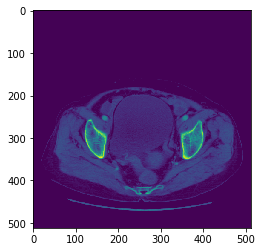

In [8]:
plt.imshow(images[0])

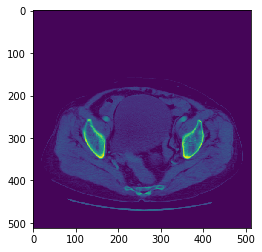

In [9]:
plt.imshow(images[1])

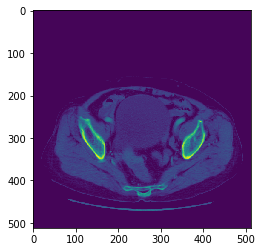

In [13]:
plt.imshow(images[2])

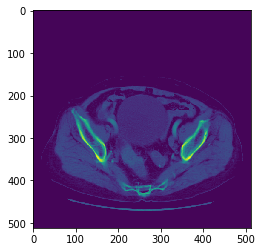

In [14]:
plt.imshow(images[3])

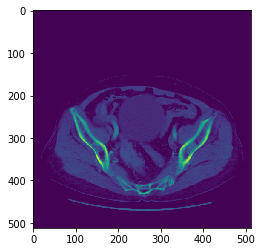

In [15]:
plt.imshow(images[4])

In [16]:
seed=1
#outputPath = "./data_train/all_liver.h5"
full_images2 = []
full_livers2 = []
for i in range(1,108):#后3个人作为测试样本
    if i != 2:
        continue
    if i == 16:
        continue
    data_path = './train/train/' + str(i+1000) + '/arterial phase'
    image_slices = [pydicom.dcmread(data_path + '/' + s) for s in os.listdir(data_path) if '.dcm' in s ]
    image_slices.sort(key = lambda x: int(x.InstanceNumber), reverse = True)#实验证明！逆序的！
    intercept = image_slices[0].RescaleIntercept
    slope = image_slices[0].RescaleSlope
    del image_slices
    livers = get_livers(data_path)
#================================================
    """ 省略进行的预处理操作，具体见part2"""
    #part2
    # 接part1
    images = get_pixels_hu_by_simpleitk(data_path, intercept, slope)
    images = transform_ctdata(images,3970,860)
    start,end = getRangImageDepth(livers)
    images = clahe_equalized(images,start,end)
    images /= 255.
    # 仅提取腹部所有切片中包含了肝脏的那些切片，其余的不要
    total = (end ) - (start) +1
    print("%d person, total slices %d"%(i,total))
    # 首和尾目标区域都太小，舍弃
    images = images[start:end]
    print("%d person, images.shape:(%d,)"%(i,images.shape[0]))
    livers[livers>0] = 1
    livers = livers[start:end]
    
   #=================================================
#     full_images2.append(images)
#     full_livers2.append(livers)
    
    print("%d Time finished"%(i))


# full_images2 = np.vstack(full_images2)
# full_images2 = np.expand_dims(full_images2,axis=-1)
# full_livers2 = np.vstack(full_livers2)
# full_livers2 = np.expand_dims(full_livers2,axis=-1)

F:\Anaconda\envs\tensorflow-gpu\lib\site-packages\pydicom\filereader.py:399: UserWarning: Expected implicit VR, but found explicit VR - using explicit VR for reading
  warnings.warn(message, UserWarning)


2 person, total slices 6
2 person, images.shape:(5,)
2 Time finished


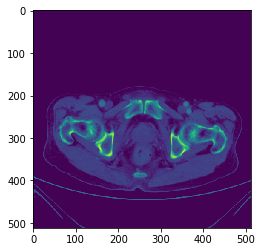

In [17]:
plt.imshow(images[0])

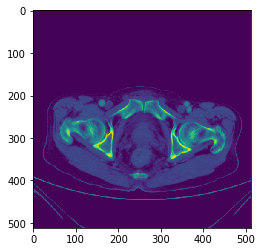

In [18]:
plt.imshow(images[1])

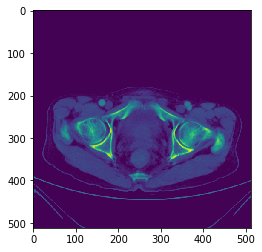

In [19]:
plt.imshow(images[2])

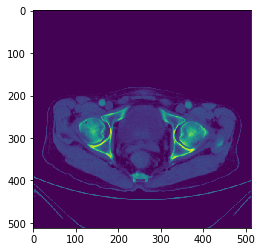

In [20]:
plt.imshow(images[3])

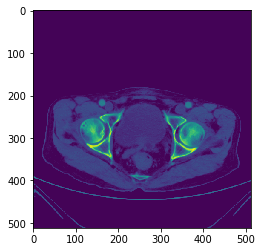

In [21]:
plt.imshow(images[4])

In [23]:
seed=1
#outputPath = "./data_train/all_liver.h5"
full_images2 = []
full_livers2 = []
for i in range(1,108):#后3个人作为测试样本
    if i != 3:
        continue
    if i == 16:
        continue
    data_path = './train/train/' + str(i+1000) + '/arterial phase'
    image_slices = [pydicom.dcmread(data_path + '/' + s) for s in os.listdir(data_path) if '.dcm' in s ]
    image_slices.sort(key = lambda x: int(x.InstanceNumber), reverse = True)#实验证明！逆序的！
    intercept = image_slices[0].RescaleIntercept
    slope = image_slices[0].RescaleSlope
    del image_slices
    livers = get_livers(data_path)
#================================================
    """ 省略进行的预处理操作，具体见part2"""
    #part2
    # 接part1
    images = get_pixels_hu_by_simpleitk(data_path, intercept, slope)
    images = transform_ctdata(images,3970,860)
    start,end = getRangImageDepth(livers)
    images = clahe_equalized(images,start,end)
    images /= 255.
    # 仅提取腹部所有切片中包含了肝脏的那些切片，其余的不要
    total = (end ) - (start) +1
    print("%d person, total slices %d"%(i,total))
    # 首和尾目标区域都太小，舍弃
    images = images[start:end]
    print("%d person, images.shape:(%d,)"%(i,images.shape[0]))
    livers[livers>0] = 1
    livers = livers[start:end]
    
   #=================================================
#     full_images2.append(images)
#     full_livers2.append(livers)
    
    print("%d Time finished"%(i))


# full_images2 = np.vstack(full_images2)
# full_images2 = np.expand_dims(full_images2,axis=-1)
# full_livers2 = np.vstack(full_livers2)
# full_livers2 = np.expand_dims(full_livers2,axis=-1)

3 person, total slices 3
3 person, images.shape:(2,)
3 Time finished


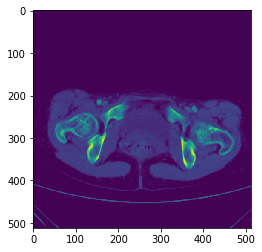

In [24]:
plt.imshow(images[0])

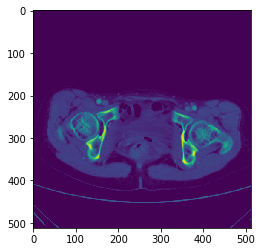

In [25]:
plt.imshow(images[1])

# 矩阵images和livers可以由np.save函数保存

1

# 找到他妈的正确求体积的方法了

https://blog.csdn.net/yaoliuwei1426/article/details/85680152 

In [2]:
from PIL import Image
import numpy as np
import pydicom
import os

# def get_livers(data_path):
#     reader = sitk.ImageSeriesReader()
#     dicom_names = reader.GetGDCMSeriesFileNames(data_path)
#     dicom_names = [s[:-4]+'_mask.png' for s in dicom_names ]
#     livers = np.array([plt.imread(s) for s in dicom_names])
#     return livers

def get_pixels_No(data_dir):
    pixels_No = 0
    mask_files = os.listdir(data_dir)
    for mask in mask_files:
        if 'mask' not  in mask:
            continue
        mask_file = os.path.join(data_dir,mask)
        img = Image.open(mask_file)
        img_array = np.array(img)
        # img_array.dtype为布尔类型，需要转换为Int类型，其累加和恰好为体素总和
        img_array_int = img_array.astype(int)
        pixels_No = pixels_No+img_array_int.sum()
    return pixels_No
 
def get_pixel_info(dcm_data_dir):
 
    pixel_infos = []
    dcm_files = os.listdir(dcm_data_dir)
    dcm_files = [s for s in dcm_files if '.dcm' in s]
    dcm_file_1 = os.path.join(dcm_data_dir,dcm_files[0])
    dcm_tag_1 = pydicom.read_file(dcm_file_1)
    # 获取像素间距.
    spacex, spacey = dcm_tag_1.PixelSpacing
    # 获取层间距
    # 有些 dcm图像并不是按照InstanceNumber进行排序的，不能直接用最后一张的slicelocation减去第一张，再除以张数
    SliceLocations = []
    ImagePositon_z = []
    for dcm in dcm_files:
        dcm_file = os.path.join(dcm_data_dir, dcm)
        dcm_tag = pydicom.read_file(dcm_file)
        SliceLocations.append(dcm_tag.SliceLocation)
        ImagePositon_z.append(dcm_tag.ImagePositionPatient[2])
    SliceLocations_max =max(SliceLocations)
    SliceLocations_min =min(SliceLocations)
    ImagePositon_z_max = max(ImagePositon_z)
    ImagePositon_z_min = min(ImagePositon_z)
    print(SliceLocations_max)
    print(SliceLocations_min)
    print(ImagePositon_z_max)
    print(ImagePositon_z_min)
    if SliceLocations_max - SliceLocations_min < 1e-10:
        spacez = abs(ImagePositon_z_max - ImagePositon_z_min)/(len(dcm_files)-1)
    else:
        spacez = abs(SliceLocations_max - SliceLocations_min)/(len(dcm_files)-1)
    pixel_infos = [spacex, spacey, spacez]
 
    return pixel_infos
 
def get_volume(dcm_data_dir,bmp_data_dir):
    pixel_infos = get_pixel_info(dcm_data_dir)
    pixels_No = get_pixels_No(bmp_data_dir)
    volume=pixel_infos[0]*pixel_infos[1]*pixel_infos[2]*pixels_No/1000
    return volume
 
# dcm = pydicom.read_file(r"E:\20181210090945_LENG HONGYING F-44Y\Venous\0000.dcm")
# print(dcm)
# print(dcm.ImagePositionPatient[2])
# print(dcm[0x0020, 0x0032].keyword,dcm[0x0020, 0x0032].value)

In [4]:
i = 1
data_dir =  './train/train/' + str(i+1000) + '/arterial phase'
volume=get_volume(data_dir,data_dir)
print("体积为%.1f"%volume)

-220.5
-315.5
-220.5
-315.5
体积为5834.9


In [15]:
volumes = {}
for i in range(1,109):
    if i == 16:
        volumes['volume_'+str(16)] = 0
    else:
        data_dir =  './train/train/' + str(i+1000) + '/arterial phase'
        volume=get_volume(data_dir,data_dir)
        volumes[ 'volume_'+str(i) ] = volume 

-220.5
-315.5
-220.5
-315.5


F:\Anaconda\envs\tensorflow-gpu\lib\site-packages\pydicom\filereader.py:399: UserWarning: Expected implicit VR, but found explicit VR - using explicit VR for reading
  warnings.warn(message, UserWarning)


-10.07
-190.07
190.07
10.07
-15.98
-130.98
130.98
15.98
-165.750
-310.750
-165.750
-310.750
-257.000
-347.000
-257.000
-347.000
47.64
-97.36
97.36
-47.64
-104.79
-299.79
299.79
104.79
-279.75
-399.75
-279.75
-399.75
-254.000
-379.000
-254.000
-379.000
-315.250
-415.250
-315.250
-415.250
-254.000
-404.000
-254.000
-404.000
-42.19
-227.19
227.19
42.19
-76.55
-206.55
206.55
76.55
-324.750
-419.750
-324.750
-419.750
-484.250
-619.250
-484.250
-619.250
-328.500
-473.500
-328.500
-473.500
-251.250
-391.250
-251.250
-391.250
-61.56
-216.56
216.56
61.56
-187.750
-282.750
-187.750
-282.750
-64.49
-199.49
199.49
64.49
38.78
-126.22
126.22
-38.78
-65.79
-170.79
170.79
65.79
-251.000
-356.000
-251.000
-356.000
16.86
-133.14
133.14
-16.86
-259.500
-354.500
-259.500
-354.500
-292.250
-382.250
-292.250
-382.250
-296.500
-426.500
-296.500
-426.500
-78.26
-253.26
253.26
78.26
-205.750
-315.750
-205.750
-315.750
-562.94
-712.94
712.94
562.94
-250.25
-345.25
-250.25
-345.25
-286.000
-476.000
-286.000
-47

In [16]:
print(volumes)

{'volume_1': 5834.919302796264, 'volume_2': 5341.753363609314, 'volume_3': 2020.3415451049802, 'volume_4': 31537.08277138931, 'volume_5': 8266.3588286976, 'volume_6': 6348.691792488098, 'volume_7': 2810.2378043174745, 'volume_8': 13971.404985011248, 'volume_9': 8275.061668410352, 'volume_10': 3830.5883720284787, 'volume_11': 6210.480308861972, 'volume_12': 10927.181934070588, 'volume_13': 6808.298349380493, 'volume_14': 1985.5863529249334, 'volume_15': 10026.197204589844, 'volume_16': 0, 'volume_17': 5841.613794882997, 'volume_18': 9530.948383881414, 'volume_19': 8026.129961013794, 'volume_20': 11216.621491320722, 'volume_21': 41471.21787071228, 'volume_22': 7562.716798782349, 'volume_23': 3709.674911499023, 'volume_24': 4027.406439378422, 'volume_25': 12014.99893913269, 'volume_26': 5429.902531548933, 'volume_27': 4710.349549433277, 'volume_28': 2724.6582793002285, 'volume_29': 9106.92572593689, 'volume_30': 8190.041618908845, 'volume_31': 16591.466188430786, 'volume_32': 12222.803651

In [17]:
import pandas as pd
data = pd.DataFrame()
data['volume'] = list(volumes.values())
data['ID'] = [i for i in range(1,109)]
data.to_csv('volumes.csv', encoding='utf-8', index=None)